In [3]:
#Nvidia Financial Time Series Coursework – Complete Analysis
#Author: Olubukola Soneye (P2892770)

In [4]:
import math                              #Import math for mathematical functions
import numpy as np                       #Import numpy for numerical manipulations
import pandas as pd                      #Import pandas for data manipulation and analysis
import matplotlib.pyplot as plt          #Import matplotlib for potting 
import seaborn as sns                    #Import seaborn for statistical data visualisation
import warnings        
import os
warnings.filterwarnings('ignore')       

In [5]:
#Importing the libraries needed for financial time series and forecasting
from sklearn.metrics import mean_absolute_error, mean_squared_error   #Forecast accuracy metrics
from statsmodels.tsa.seasonal import seasonal_decompose               #Time series decomposition
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 
from statsmodels.tsa.stattools import adfuller                         
from statsmodels.tsa.arima.model import ARIMA                          #ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX                # SARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf         # ACF & PACF plots
from statsmodels.stats.diagnostic import acorr_ljungbox               #Ljung–Box test
import statsmodels.api as sm                                          # Regression tools

In [6]:
#Adding the settings for plotting
plt.style.use('seaborn-v0_8-whitegrid')    # Use clean white grid style
sns.set_palette("husl")                    # Set consistent colour palette

In [7]:
import os

DATA_DIR = "/kaggle/input/nvidia-financial-time-series"  #Path to the dataset
CSV_PATH = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[0])

H = 6  # Forecast horizon (months)

In [8]:
#Data loading and preprocessing
df = pd.read_csv(CSV_PATH)

# Converting the date column to datetime format
df["Date"] = pd.to_datetime(
    df["Date"],
    format="mixed",
    dayfirst=True
)

# Identifying the closing price column and cleaning currency symbols
close_col = "Close/Last" if "Close/Last" in df.columns else "Close"

df["Close"] = (
    df[close_col]
    .astype(str)
    .str.replace("$", "", regex=False)
    .astype(float)
)

#Sorting chronologically and setting the date as index
df = df.sort_values("Date").set_index("Date")

monthly = df["Close"].resample("M").last().dropna()

#View the output - dataset structure
print("\nDataset Information:")
print(f"  Total observations: {len(monthly)}")
print(f"  Date range: {monthly.index.min().strftime('%B %Y')} "
      f"to {monthly.index.max().strftime('%B %Y')}")
print("  Frequency: Monthly (end-of-month)")


Dataset Information:
  Total observations: 66
  Date range: January 2021 to September 2026
  Frequency: Monthly (end-of-month)



Train-Test Split:
  Training set: 60 observations
  Test set: 6 observations (6 months)

Descriptive Statistics:
count     66.000000
mean      78.978002
std       65.380644
min       12.139000
25%       20.180875
50%       46.749500
75%      130.800000
max      202.490000
Name: Close, dtype: float64


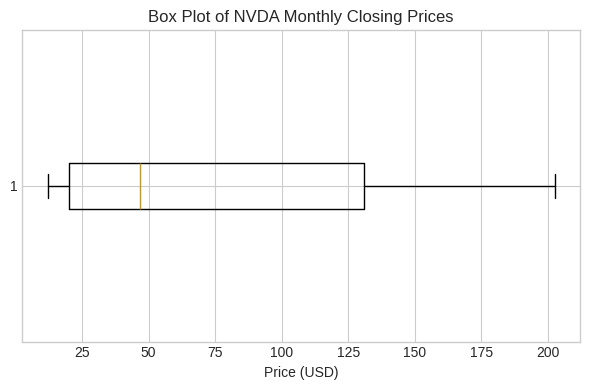

In [9]:
#ACTIVITY 1
#Split the data to train and test
train = monthly.iloc[:-H]
test = monthly.iloc[-H:]

print("\nTrain-Test Split:")
print(f"  Training set: {len(train)} observations")
print(f"  Test set: {len(test)} observations ({H} months)")

print("\nDescriptive Statistics:")
print(monthly.describe())

#Box plot of monthly closing prices to show distribution
plt.figure(figsize=(6, 4))
plt.boxplot(monthly, vert=False)
plt.title("Box Plot of NVDA Monthly Closing Prices")
plt.xlabel("Price (USD)")
plt.tight_layout()
plt.show()

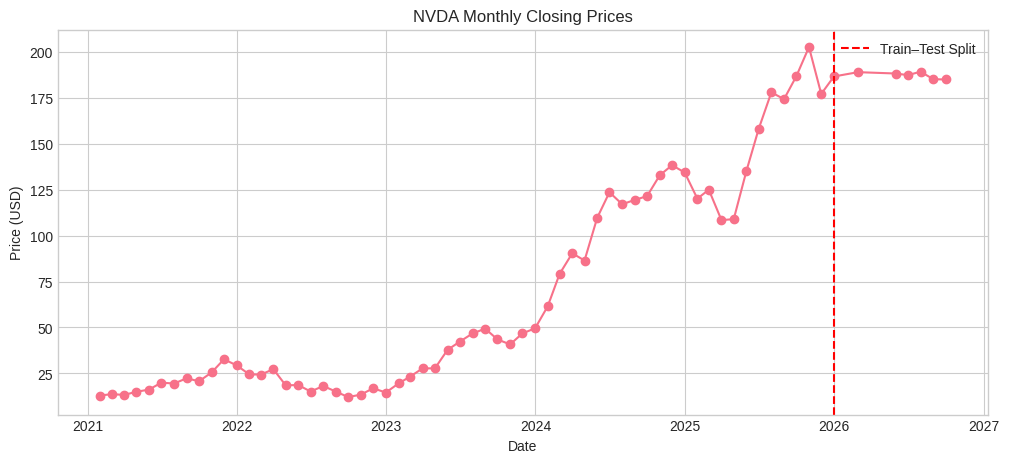

In [10]:
#Exploratory data analysis
#Visualisation of the monthly time series (Linear scale plot)
plt.figure(figsize=(12, 5))
plt.plot(monthly.index, monthly.values, marker='o')
plt.axvline(train.index[-1], color='red', linestyle='--', label='Train–Test Split')
plt.title("NVDA Monthly Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

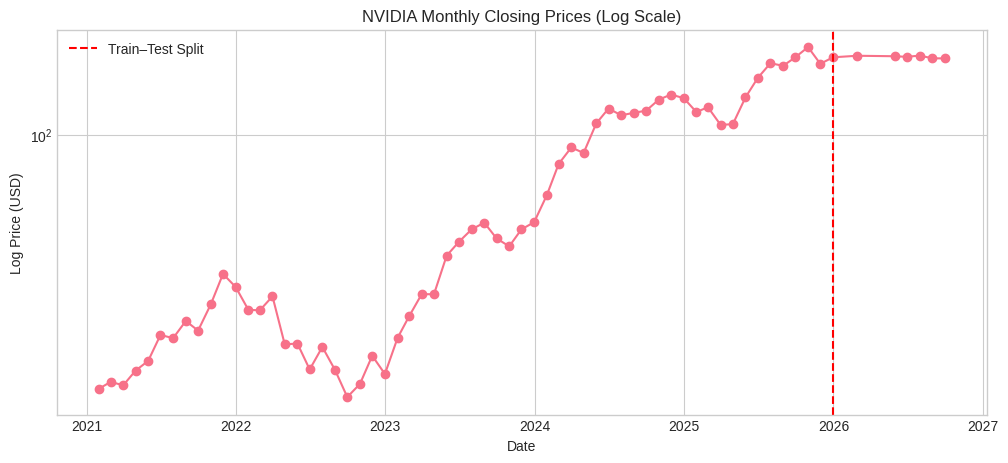

In [11]:
#Visualisation of the monthly time series (Logarithm scale plot)
plt.figure(figsize=(12, 5))
plt.plot(monthly.index, monthly.values, marker='o')
plt.yscale("log")
plt.axvline(train.index[-1], color='red', linestyle='--', label='Train–Test Split')
plt.title("NVIDIA Monthly Closing Prices (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Log Price (USD)")
plt.legend()
plt.show()

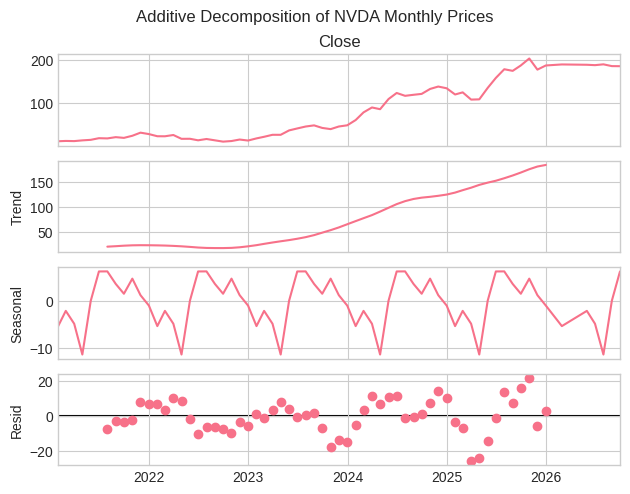

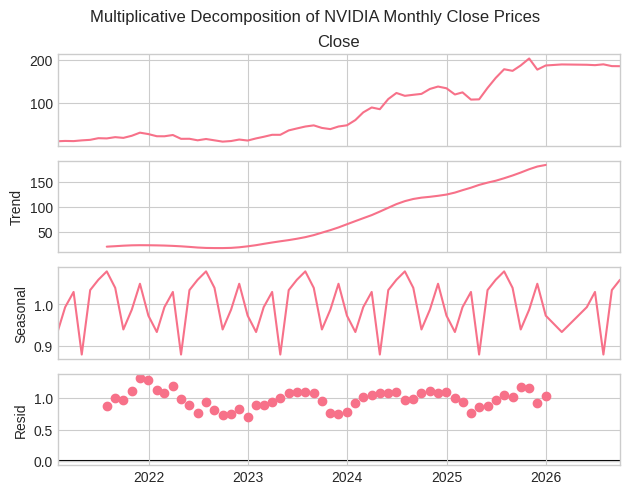

In [12]:
#Decomposign the series into trend, seasonal, and residual using a 12-month seasonal period
#Additive decomposition
decomp_add = seasonal_decompose(monthly, model='additive', period=12)
decomp_add.plot()
plt.suptitle("Additive Decomposition of NVDA Monthly Prices", y=1.02)
plt.show()

#Multiplicative decomposition
decomp_mult = seasonal_decompose(monthly, model="multiplicative", period=12)
decomp_mult.plot()
plt.suptitle("Multiplicative Decomposition of NVIDIA Monthly Close Prices", y=1.02)
plt.show()

In [13]:
#Classical forecasting methods
results = {}
forecasts = {}

#Fixing the forecast horizon to match the test set
h = len(test)

#Naïve (random walk) forecast
forecasts["Naïve"] = pd.Series([train.iloc[-1]] * h, index=test.index)

#Historical mean forecast
forecasts["Historical Mean"] = pd.Series([train.mean()] * h, index=test.index)

#Simple Moving Average 
sma_vals = []
history = train.copy()

for i in range(h):
    sma_next = history.iloc[-3:].mean()
    sma_vals.append(sma_next)
    history = pd.concat([history, pd.Series([sma_next], index=[test.index[i]])])


forecasts["SMA(3)"] = pd.Series(sma_vals, index=test.index)

#Simple Exponential Smoothing
ses = SimpleExpSmoothing(train).fit(optimized=True)
forecasts["SES"] = ses.forecast(h)
print(f"\nSES alpha (α): {ses.params['smoothing_level']:.4f}")

#Holt’s Linear Trend
holt = ExponentialSmoothing(train, trend="add").fit(optimized=True)
forecasts["Holt"] = holt.forecast(h)
print(f"Holt alpha (α): {holt.params['smoothing_level']:.4f}")
print(f"Holt beta (β): {holt.params['smoothing_trend']:.4f}")

#Holt–Winters 
hw_add = ExponentialSmoothing(
    train, trend="add", seasonal="add", seasonal_periods=12
).fit(optimized=True)
forecasts["Holt-Winters"] = hw_add.forecast(h)
print(f"Holt-Winters alpha (α): {hw_add.params['smoothing_level']:.4f}")
print(f"Holt-Winters beta (β): {hw_add.params['smoothing_trend']:.4f}")
print(f"Holt-Winters gamma (γ): {hw_add.params['smoothing_seasonal']:.4f}")


SES alpha (α): 1.0000
Holt alpha (α): 1.0000
Holt beta (β): 0.0000
Holt-Winters alpha (α): 1.0000
Holt-Winters beta (β): 0.0465
Holt-Winters gamma (γ): 0.0000


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [14]:
#Evaluating the forecasts using MAE, MSE and MAPE
def mape(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    mask = y != 0
    return np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100


def metrics(y, yhat):
    # Aligning series and drop missing values
    df_eval = pd.concat([y, yhat], axis=1).dropna()
    y_clean = df_eval.iloc[:, 0]
    yhat_clean = df_eval.iloc[:, 1]

    return {
        "MAE": mean_absolute_error(y_clean, yhat_clean),
        "MSE": mean_squared_error(y_clean, yhat_clean),
        "MAPE": mape(y_clean, yhat_clean)
    }


#Computing accuracy metrics for each forecasting method
for name, fc in forecasts.items():
    results[name] = metrics(test, fc)

#View the forecast accuracy
print("Activity 1 – Forecast Accuracy:")
print(pd.DataFrame(results).T.sort_values("MSE"))

Activity 1 – Forecast Accuracy:
                        MAE           MSE       MAPE
SES                1.570000      2.898167   0.833580
Naïve              1.736667      3.387967   0.926178
SMA(3)             1.610681      4.447224   0.858042
Holt              11.173679    156.484184   5.951314
Holt-Winters      18.721388    461.542866   9.973959
Historical Mean  119.047865  14175.287450  63.589797


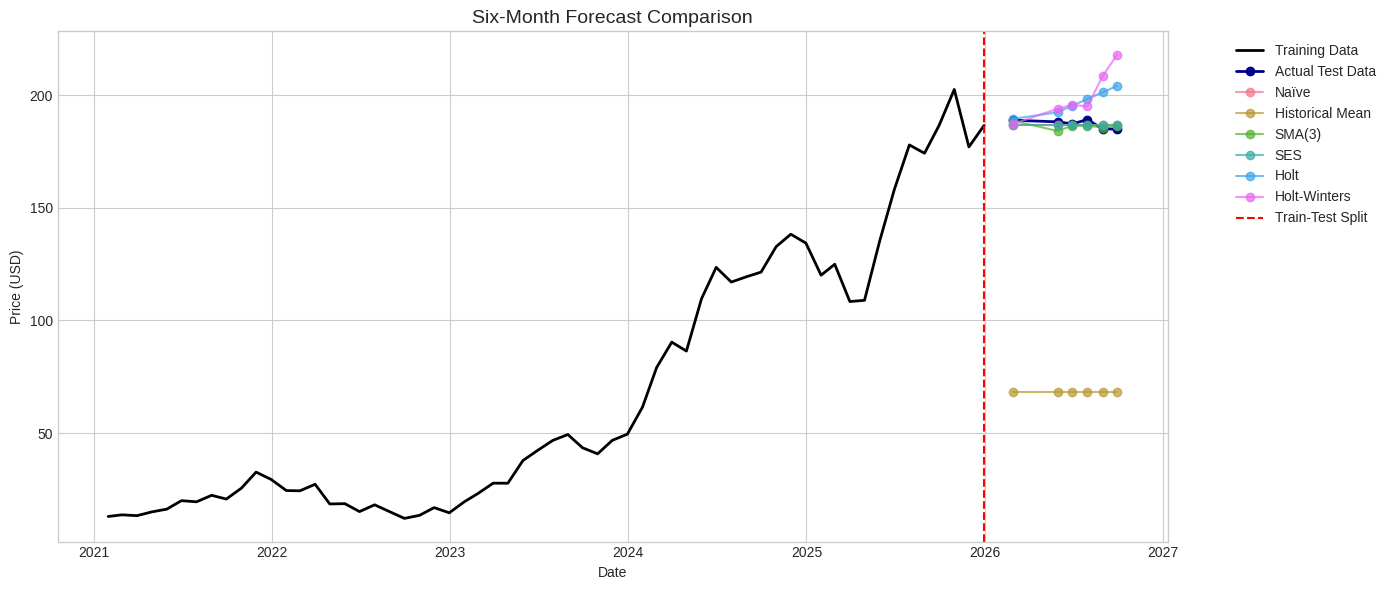

In [15]:
#Comparing all forecasting methods
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Training Data', color='black', linewidth=2)
plt.plot(test.index, test.values, label='Actual Test Data',
         color='darkblue', marker='o', linewidth=2)

for name, fc in forecasts.items():
    plt.plot(test.index, fc.values, label=name, marker='o', alpha=0.7)

plt.axvline(train.index[-1], color='red', linestyle='--', label='Train-Test Split')
plt.title("Six-Month Forecast Comparison", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
#ACTIVITY 2 
#Stationary and ARIMA modelling
log_prices = np.log(monthly)
log_returns = log_prices.diff().dropna()

adf_result = adfuller(log_returns)
print("\nADF Test on Log Returns:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Test on Log Returns:
ADF Statistic: -7.6114
p-value: 0.0000


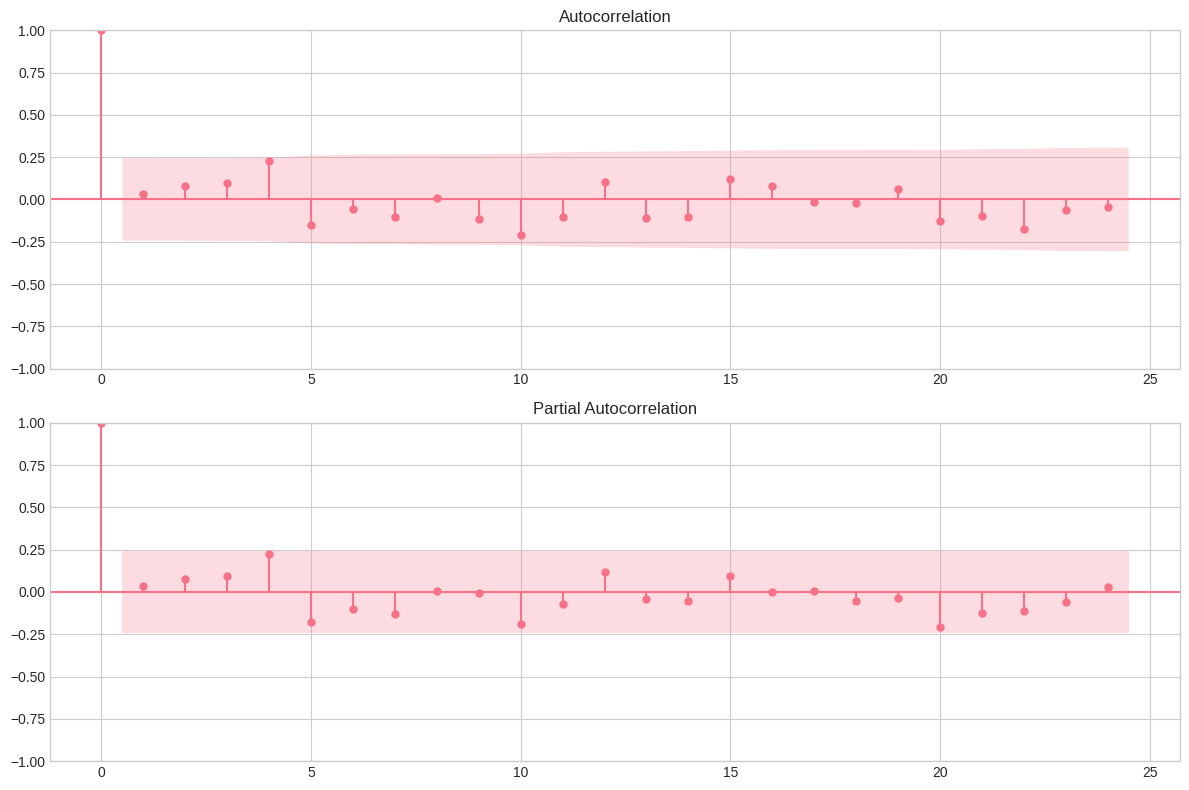

In [17]:
#ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(log_returns, lags=24, ax=axes[0])
plot_pacf(log_returns, lags=24, ax=axes[1], method="ywm")

plt.tight_layout()
plt.show()

In [18]:
#ARIMA AND SARIMA MODELLING
#Ensuring the monthly frequency is explicitly set to mitigate against statsmodels warnings
train = train.asfreq("M")
test = test.asfreq("M")


#Selecting the ARIMA model via AIC
aic_results = []

for p in range(0, 3):
    for q in range(0, 3):
        try:
            model = ARIMA(np.log(train), order=(p, 1, q)).fit()
            aic_results.append({
                "Model": f"ARIMA({p},1,{q})",
                "AIC": model.aic,
                "BIC": model.bic
            })
        except:
            continue

aic_df = pd.DataFrame(aic_results).sort_values("AIC")
print("\nARIMA Model Selection (AIC):")
print(aic_df.to_string(index=False))

#Final ARIMA and SARIMA model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima = ARIMA(
    np.log(train),
    order=(0, 1, 0)
).fit()

arima_fc = np.exp(arima.forecast(H))
results["ARIMA"] = metrics(test, arima_fc)

print(arima.summary())


sarima = SARIMAX(
    np.log(train),
    order=(0, 1, 0),
    seasonal_order=(0, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_fc = np.exp(sarima.forecast(H))
results["SARIMA"] = metrics(test, sarima_fc)

print(sarima.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA Model Selection (AIC):
       Model        AIC        BIC
ARIMA(0,1,0) -54.661956 -52.584419
ARIMA(1,1,1) -53.742055 -47.509443
ARIMA(1,1,0) -53.395612 -49.240537
ARIMA(0,1,1) -53.237117 -49.082042
ARIMA(1,1,2) -52.650680 -44.340531
ARIMA(2,1,0) -52.636974 -46.404361
ARIMA(0,1,2) -51.911188 -45.678575
ARIMA(2,1,1) -51.617704 -43.307555
ARIMA(2,1,2) -50.758745 -40.371058
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   60
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  28.331
Date:                Sun, 25 Jan 2026   AIC                            -54.662
Time:                        15:34:50   BIC                            -52.584
Sample:                    01-31-2021   HQIC                           -53.851
                         - 12-31-2025                                         
Covariance Type:                  opg                              

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   60
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  28.331
Date:                Sun, 25 Jan 2026   AIC                            -54.662
Time:                        15:34:50   BIC                            -52.584
Sample:                    01-31-2021   HQIC                           -53.851
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0224      0.005      4.722      0.000       0.013       0.032
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.84   Pr

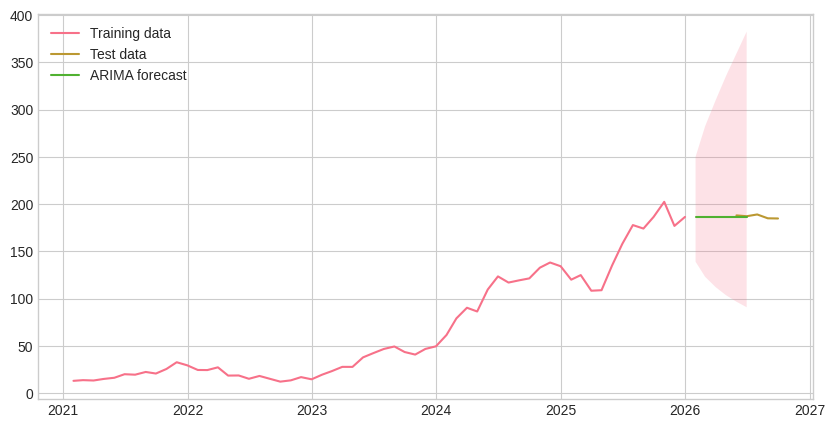

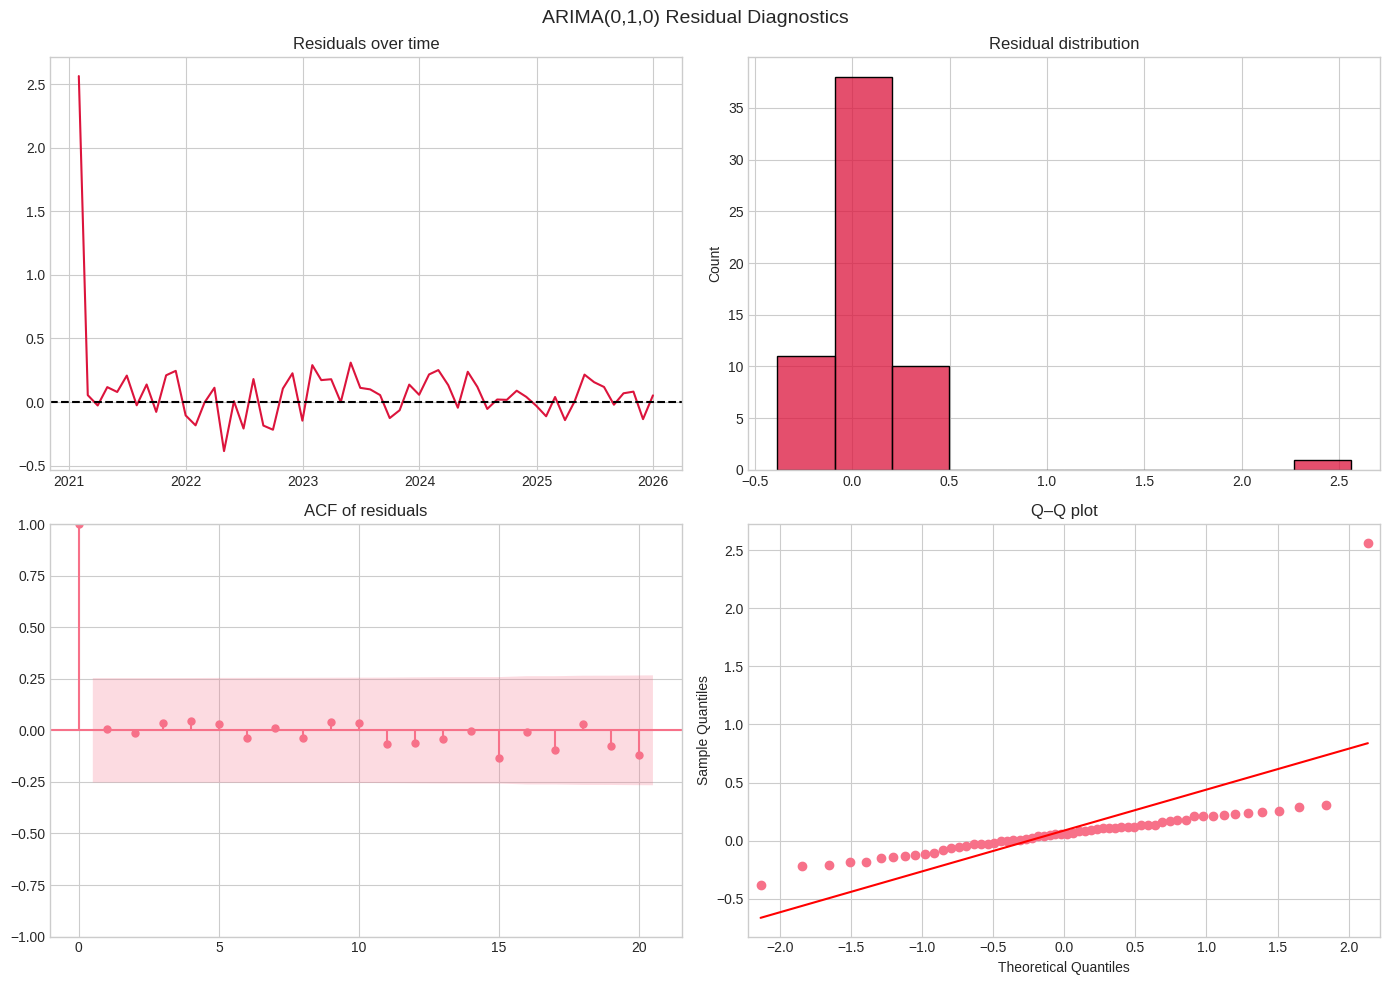


Ljung–Box test:
    lb_stat  lb_pvalue
10  0.69511   0.999968


In [19]:
#ARIMA Modelling
from statsmodels.tsa.arima.model import ARIMA

#Fit ARIMA(0,1,0) on log prices
arima = ARIMA(np.log(train), order=(0, 1, 0)).fit()

#Print model summary 
print(arima.summary())

arima_forecast = arima.get_forecast(steps=6)

forecast_mean = arima_forecast.predicted_mean
forecast_ci = arima_forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Training data")
plt.plot(test.index, test, label="Test data")
plt.plot(forecast_mean.index, np.exp(forecast_mean), label="ARIMA forecast")
plt.fill_between(
    forecast_mean.index,
    np.exp(forecast_ci.iloc[:, 0]),
    np.exp(forecast_ci.iloc[:, 1]),
    alpha=0.2
)
plt.legend()
plt.show()


#Residual diagnostics for ARIMA(0,1,0)
residuals = arima.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Residuals over time
axes[0, 0].plot(residuals, color='crimson')
axes[0, 0].axhline(0, linestyle='--', color='black')
axes[0, 0].set_title("Residuals over time")

#Residual distribution
sns.histplot(residuals, bins=10, ax=axes[0, 1], color='crimson')
axes[0, 1].set_title("Residual distribution")

#ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("ACF of residuals")

#Q–Q plot
sm.qqplot(residuals, line='s', ax=axes[1, 1])
axes[1, 1].set_title("Q–Q plot")

plt.suptitle("ARIMA(0,1,0) Residual Diagnostics", fontsize=14)
plt.tight_layout()
plt.show()

#Ljung–Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung–Box test:")
print(lb_test)

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                  29.266
Date:                              Sun, 25 Jan 2026   AIC                            -54.533
Time:                                      15:47:44   BIC                            -50.377
Sample:                                  01-31-2021   HQIC                           -52.911
                                       - 12-31-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.1893      0.147      1.292      0.196      -0.098       0.477
sigma2         0.02

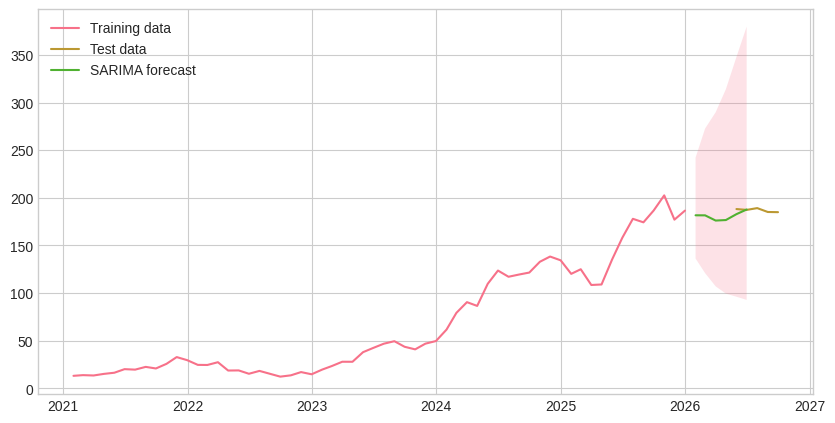

In [28]:
# SARIMA forecasting
print(sarima.summary())

sarima_forecast = sarima.get_forecast(steps=6)

sarima_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Training data")
plt.plot(test.index, test, label="Test data")
plt.plot(sarima_mean.index, np.exp(sarima_mean), label="SARIMA forecast")
plt.fill_between(
    sarima_mean.index,
    np.exp(sarima_ci.iloc[:, 0]),
    np.exp(sarima_ci.iloc[:, 1]),
    alpha=0.2
)
plt.legend()
plt.show()

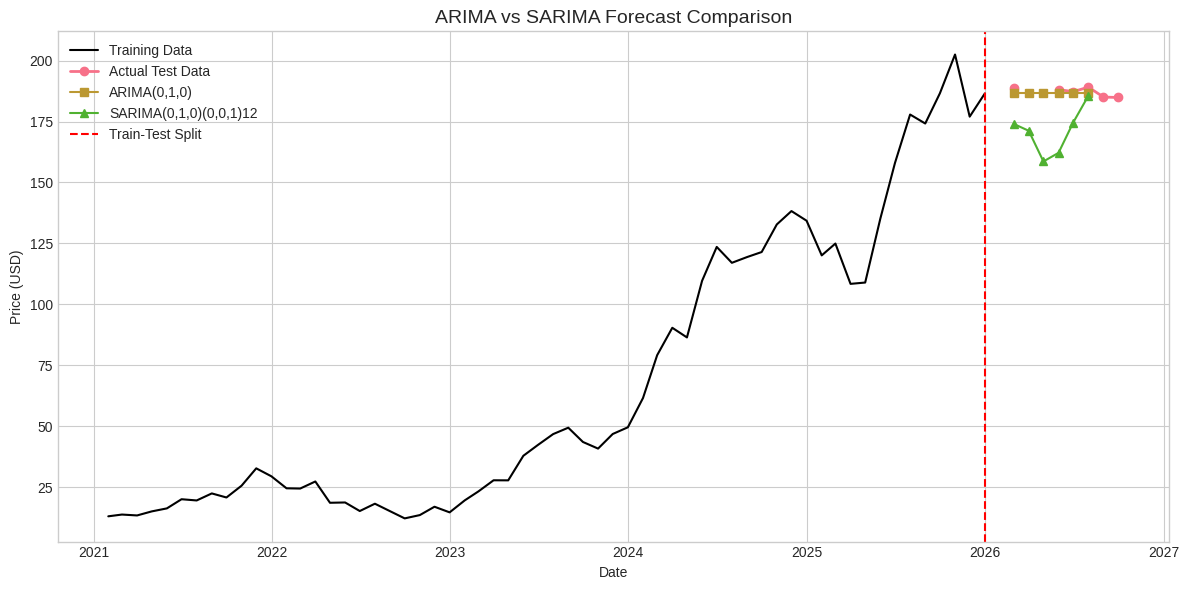

In [20]:
#Comparing ARIMA vs SARIMA forecast performance
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Training Data', color='black')
plt.plot(test.index, test.values, label='Actual Test Data',
         marker='o', linewidth=2)

plt.plot(test.index[:H], arima_fc.values, label='ARIMA(0,1,0)', marker='s')
plt.plot(test.index[:H], sarima_fc.values, label='SARIMA(0,1,0)(0,0,1)12', marker='^')

plt.axvline(train.index[-1], color='red', linestyle='--', label='Train-Test Split')
plt.title("ARIMA vs SARIMA Forecast Comparison", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
#Fitting a regression model using lagged monthly log returns
reg = pd.DataFrame({"r": log_returns})

for i in range(1, 4):
    reg[f"lag{i}"] = reg["r"].shift(i)

reg = reg.dropna()

#Training set 
reg_train = reg.iloc[:-H]

#Defining the dependent and independent variables
y = reg_train["r"]
X = sm.add_constant(reg_train[["lag1", "lag2", "lag3"]])

reg_model = sm.OLS(y, X).fit()

print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.2172
Date:                Sun, 25 Jan 2026   Prob (F-statistic):              0.884
Time:                        15:34:51   Log-Likelihood:                 28.695
No. Observations:                  56   AIC:                            -49.39
Df Residuals:                      52   BIC:                            -41.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0368      0.023      1.609      0.1

In [22]:
#ACTIVITY 3
#Forecasting with regression model 

reg_fc = []
last_obs = reg.iloc[-1]

for i in range(H):
    X_next = pd.DataFrame(
        [[1, last_obs["lag1"], last_obs["lag2"], last_obs["lag3"]]],
        columns=["const", "lag1", "lag2", "lag3"]
    )

    r_hat = reg_model.predict(X_next)[0]
    reg_fc.append(r_hat)

    last_obs = pd.Series({
        "r": r_hat,
        "lag1": r_hat,
        "lag2": last_obs["lag1"],
        "lag3": last_obs["lag2"]
    })

#Convertign the return forecasts back to prices
last_price = train.iloc[-1]
price_fc = last_price * np.exp(np.cumsum(reg_fc))

reg_price_fc = pd.Series(price_fc, index=test.index[:H])

results["Regression"] = metrics(test.iloc[:H], reg_price_fc)

print("Regression forecast accuracy:")
print(results["Regression"])

Regression forecast accuracy:
{'MAE': 30.718683768426715, 'MSE': 1215.8283937887309, 'MAPE': np.float64(16.31830216642293)}


In [23]:
#Final forecast accuracy comparison 
final_results = pd.DataFrame(results).T.sort_values("MAE")

print("\nFINAL FORECAST COMPARISON")
print(final_results.to_string())

print(f"\nBest MAE model: {final_results.index[0]}")
print(f"Best MSE model: {final_results['MSE'].idxmin()}")
print(f"Best MAPE model: {final_results['MAPE'].idxmin()}")



FINAL FORECAST COMPARISON
                        MAE           MSE       MAPE
ARIMA              1.570000      2.898167   0.833580
SES                1.570000      2.898167   0.833580
SMA(3)             1.610681      4.447224   0.858042
Naïve              1.736667      3.387967   0.926178
SARIMA            10.959699    165.946518   5.815216
Holt              11.173679    156.484184   5.951314
Holt-Winters      18.721388    461.542866   9.973959
Regression        30.718684   1215.828394  16.318302
Historical Mean  119.047865  14175.287450  63.589797

Best MAE model: ARIMA
Best MSE model: ARIMA
Best MAPE model: ARIMA
